# データ確認（KIMIA_Path_20クラス*48枚=960）

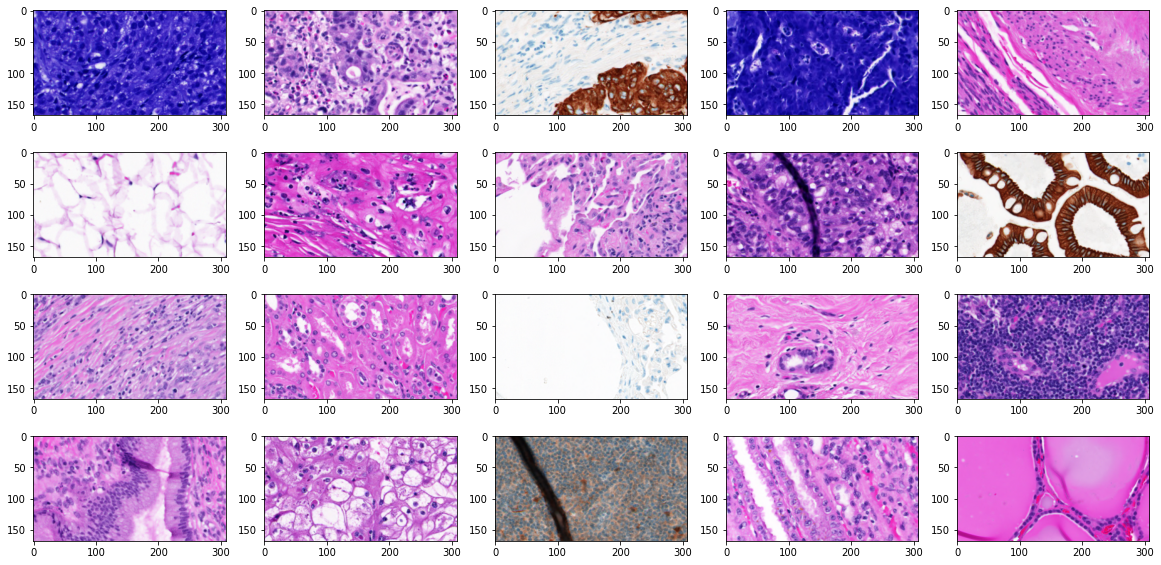

In [2]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

load = "./kimia_path_960/"
classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T"]

fig, ax = plt.subplots(2,2, figsize = (20,10))
for n in range(20):
    img = cv2.imread(load+classes[n]+"10.tif")
    plt.subplot(4,5,n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# データの読み込み

In [3]:
all_files=[]
file_label=[]
load = "./kimia_data_augment/"
# load = "./kimia_path_960/"
for root,dirs,files in os.walk(load):
    for file_name in files:
        file = os.path.join(root+file_name)
        label = os.path.join(file_name)
        all_files.append(file)
        file_label.append(label[0])
        
# all_files.remove("./KIMIA_Path_960/.DS_Store")
# file_label.remove(".")
print(len(all_files))
print(len(file_label))

6720
6720


# 拡張データ確認

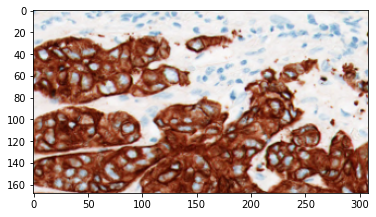

In [2]:
img = cv2.imread('./kimia_path_960/C30.tif')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

['./kimia_path_960/C30.tif', './kimia_data_augment/C30_2625.tif', './kimia_data_augment/C30_2621.tif', './kimia_data_augment/C30_2619.tif', './kimia_data_augment/C30_2623.tif', './kimia_data_augment/C30_2620.tif', './kimia_data_augment/C30_2624.tif', './kimia_data_augment/C30_2622.tif']


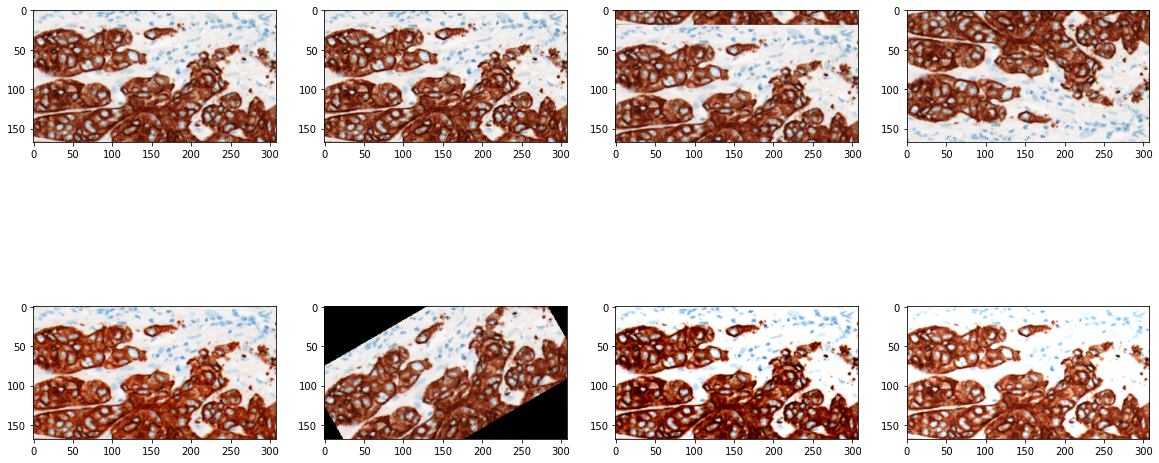

In [5]:
import re

similiardata = ["./kimia_path_960/C30.tif"]
for file in all_files:
#     print(file)
    if file.startswith("./kimia_data_augment/C30"):
        similiardata.append(file)
print(similiardata)

fig, ax = plt.subplots(2,2, figsize = (20,10))
n=1
for data in similiardata:
    img = cv2.imread(data)
    plt.subplot(2,4,n)
    n = n+1
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# データ処理

In [5]:
# y labelを数字に変換　A=>1
alphabet='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet_dict={}
for i in range(len(alphabet)):
    alphabet_dict[alphabet[i]]=i
print(alphabet_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [6]:
y_list = []
for i in file_label:
    y_list.append(alphabet_dict[i])

In [95]:
# from tqdm import tqdm,trange
# all_files_imread =[]
# for i in trange(len(all_files)):
#     all_files_imread.append(cv2.imread(all_files[i]))
# np.save('all_files_imread',all_files_imread) 

100%|██████████| 6720/6720 [25:30<00:00,  4.39it/s]  


In [7]:
all_files_imread = np.load("all_files_imread.npy")

x_train = np.array(all_files_imread)
y_train = np.array(y_list)
print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)

x_train.shape:  (6720, 168, 308, 3)
y_train.shape:  (6720,)


In [ ]:
# print(all_files[:20])
# print(y_train[:20])

# データ前処理

In [8]:
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
torch.__version__

'1.9.0+cu102'

In [9]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.y_train = y_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(y_train[idx], dtype=torch.long)

trainval_data = train_dataset(x_train, y_train)

# CNNモデル

In [10]:
batch_size = 8

val_size = int(len(trainval_data)*0.2)
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

conv_net = nn.Sequential(
    nn.Conv2d(3, 64, 3),              # Conv 168x308x3 -> 166x306x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 166x306x64 -> 83x153x64
    
    nn.Conv2d(64, 64, 3),             # Conv 83x153x64 -> 81x151x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 81x151x64 -> 40x75x64

    nn.Conv2d(64, 128, 3),            # Conv 40x75x64 -> 38x73x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 38x73x128 -> 19x36x128
    
    nn.Conv2d(128, 128, 3),            # Conv 19x36x128 -> 17x34x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 17x34x128 -> 8x17x128

    nn.Conv2d(128, 128, 3),           # Conv 8x17x128 -> 6x15x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # Pool 6x15x128 -> 3x7x128

    nn.Flatten(),
    nn.Linear(3*7*128, 1024),
#     torch.nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(1024, 256),
#     torch.nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(256, 20)
)

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

device = 'cuda'
conv_net.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
n_epochs = 50
lr = 0.005
optimizer = optim.SGD(conv_net.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        conv_net.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 2.024, Accuracy: 0.358], Valid [Loss: 1.125, Accuracy: 0.604]
EPOCH: 1, Train [Loss: 1.190, Accuracy: 0.570], Valid [Loss: 1.944, Accuracy: 0.449]
EPOCH: 2, Train [Loss: 0.933, Accuracy: 0.664], Valid [Loss: 2.889, Accuracy: 0.475]
EPOCH: 3, Train [Loss: 0.691, Accuracy: 0.759], Valid [Loss: 2.909, Accuracy: 0.464]
EPOCH: 4, Train [Loss: 0.570, Accuracy: 0.799], Valid [Loss: 0.585, Accuracy: 0.793]
EPOCH: 5, Train [Loss: 0.488, Accuracy: 0.832], Valid [Loss: 0.278, Accuracy: 0.912]


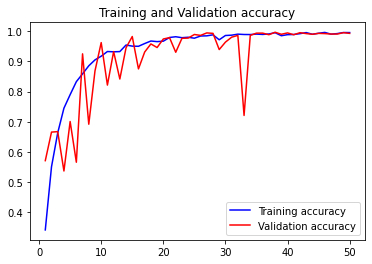

<Figure size 432x288 with 0 Axes>

In [14]:
# Data: augment6720
# Rate: 0.005
# Epochs: 50 
# Struc: 1cp1cp1cp1cp1cp 
# No Dropout

epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [34]:
grad_cam = GradCam(model=conv_net, feature_module=conv_net.layer9, target_layer_names=["2"], use_cuda=args.use_cuda)

NameError: name 'GradCam' is not defined

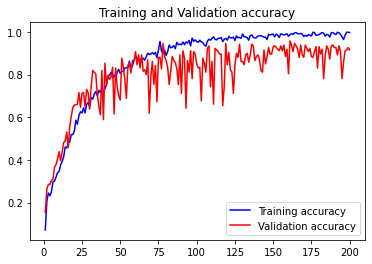

<Figure size 432x288 with 0 Axes>

In [48]:
# Data: 960  
# Rate: 0.001 
# Epochs: 200 
# Struc: 1cp1cp1cp1cp1cp 
# No Dropout

epochs=range(1,201)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

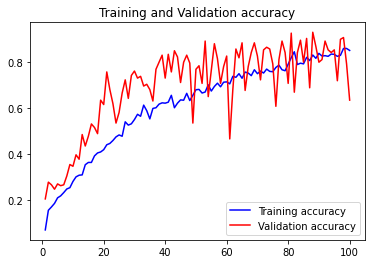

<Figure size 432x288 with 0 Axes>

In [36]:
# Data: 960  
# Rate: 0.001 
# Epochs: 100 
# Struc: 1cp1cp1cp1cp1cp 
# Dropout

epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

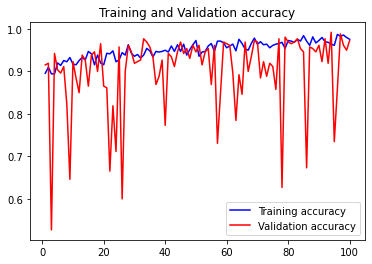

<Figure size 432x288 with 0 Axes>

In [21]:
# Data: 960  
# Rate: 0.001 
# Epochs: 100 
# Struc: 2cp2cp1cp1cp
# Dropout

epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

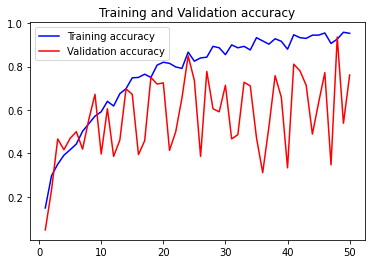

<Figure size 432x288 with 0 Axes>

In [20]:
# Datas: 960 
# Rate: 0.01 
# Epochs: 50 
# Struc: 2cp2cp1cp1cp
# Dropout

epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# Data augmentation

In [31]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import pyplot
from numpy import expand_dims

In [80]:
!rm -r kimia_data_augment

In [81]:
!mkdir kimia_data_augment

In [82]:
# -*- coding: utf-8 -*-
import sys    
import os
import time
import re
from PIL import Image,ImageChops,ImageEnhance
 
def image_reversal(img,savefilepath,save_filename):
    """ 图像翻转"""
    lr=img.transpose(Image.FLIP_LEFT_RIGHT) # 左右翻转
    ud=img.transpose(Image.FLIP_TOP_BOTTOM) # 上下翻转
    lr.save(savefilepath+save_filename)
    ud.save(savefilepath+save_filename)
 
 
def image_rotation(img,savefilepath,save_filename):
    """图像旋转"""
    out1=img.rotate(40) # 旋转20度
    out2=img.rotate(30) # 旋转30度
    out1.save(savefilepath+save_filename)
    out2.save(savefilepath+save_filename)
 
 
def image_translation(img,savefilepath,save_filename):
    """图像平移"""
    out3=ImageChops.offset(img,20,0) # 只沿X轴平移
    out4=ImageChops.offset(img,0,20) # 只沿y轴平移
    out3.save(savefilepath+save_filename)
    out4.save(savefilepath+save_filename)
 
 
def image_brightness(img,savefilepath,save_filename):
    """亮度调整"""
    bri=ImageEnhance.Brightness(img)
    bri_img1=bri.enhance(0.8) # 小于1为减弱
    bri_img2=bri.enhance(1.2) # 大于1为增强
    bri_img1.save(savefilepath+save_filename)
    bri_img2.save(savefilepath+save_filename)
 
 
def image_chroma(img,savefilepath,save_filename):
    """色度调整"""
    col = ImageEnhance.Color(img)
    col_img1 = col.enhance(0.7) # 色度减弱
    col_img2 = col.enhance(1.3) # 色度增强
    col_img1.save(savefilepath+save_filename)
    col_img2.save(savefilepath+save_filename)
 
 
def image_contrast(img,savefilepath,save_filename):
    """对比度调整"""
    con=ImageEnhance.Contrast(img)
    con_img1=con.enhance(0.7) # 对比度减弱
    con_img2=con.enhance(1.3) # 对比度增强
    con_img1.save(savefilepath+save_filename)
    con_img2.save(savefilepath+save_filename)
 
 
def image_sharpness(img,savefilepath,save_filename):
    """锐度调整"""
    sha = ImageEnhance.Sharpness(img)
    sha_img1 = sha.enhance(0.5) # 锐度减弱
    sha_img2 = sha.enhance(1.5) # 锐度增强
    sha_img1.save(savefilepath+save_filename)
    sha_img2.save(savefilepath+save_filename)
 
 
# 定义扩充图片函数
def image_expansion(filepath,savefilepath,save_prefix):
    """
    :param filepath: 图片路径
    :param savefilepath: 扩充保存图片路径
    :param save_prefix: 图片前缀
    :return: 图片扩充数据集
    """
    i = 1
    for parent, dirnames, filenames in os.walk(filepath):
        for filename in filenames:
            image_path=filepath+filename
            name = re.findall(r"(.*).tif", filename)[0]
            print('正在扩充图片：%s' %filename)
            try:
                img=Image.open(image_path)
                if img.mode == "P":
                    img = img.convert('RGB')
                image_reversal(img,savefilepath,save_filename=name + "_" + str(i) + '.tif')
                i += 1
                image_rotation(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_translation(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_brightness(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_chroma(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_contrast(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
                image_sharpness(img,savefilepath,save_filename=name+ "_" + str(i)+'.tif')
                i += 1
            except Exception as e:
                print(e)
                pass
 
 
if __name__ == '__main__':
    # 设置图片路径
    filepath = './kimia_path_960/'

    # 设置扩充保存图片路径
    savefilepath ='./kimia_data_augment/'
    
    time1 = time.time()
    image_expansion(filepath, savefilepath,save_prefix)
    time2 = time.time()
    print('总共耗时：' + str(time2 - time1) + 's')
 

正在扩充图片：C48.tif
正在扩充图片：A24.tif
正在扩充图片：Q27.tif
正在扩充图片：K42.tif
正在扩充图片：K13.tif
正在扩充图片：A2.tif
正在扩充图片：E41.tif
正在扩充图片：G26.tif
正在扩充图片：E31.tif
正在扩充图片：B13.tif
正在扩充图片：D1.tif
正在扩充图片：I29.tif
正在扩充图片：A25.tif
正在扩充图片：R5.tif
正在扩充图片：I19.tif
正在扩充图片：O3.tif
正在扩充图片：O7.tif
正在扩充图片：R30.tif
正在扩充图片：A13.tif
正在扩充图片：E22.tif
正在扩充图片：N36.tif
正在扩充图片：T35.tif
正在扩充图片：B20.tif
正在扩充图片：E25.tif
正在扩充图片：L47.tif
正在扩充图片：F9.tif
正在扩充图片：O14.tif
正在扩充图片：I18.tif
正在扩充图片：F42.tif
正在扩充图片：J41.tif
正在扩充图片：S12.tif
正在扩充图片：M15.tif
正在扩充图片：Q33.tif
正在扩充图片：S3.tif
正在扩充图片：L7.tif
正在扩充图片：D42.tif
正在扩充图片：O25.tif
正在扩充图片：T1.tif
正在扩充图片：G41.tif
正在扩充图片：H37.tif
正在扩充图片：I10.tif
正在扩充图片：R14.tif
正在扩充图片：O28.tif
正在扩充图片：S27.tif
正在扩充图片：L12.tif
正在扩充图片：S2.tif
正在扩充图片：K30.tif
正在扩充图片：C47.tif
正在扩充图片：R48.tif
正在扩充图片：H9.tif
正在扩充图片：T6.tif
正在扩充图片：R35.tif
正在扩充图片：T36.tif
正在扩充图片：F26.tif
正在扩充图片：D8.tif
正在扩充图片：I14.tif
正在扩充图片：D28.tif
正在扩充图片：Q35.tif
正在扩充图片：C42.tif
正在扩充图片：R1.tif
正在扩充图片：O24.tif
正在扩充图片：I34.tif
正在扩充图片：F4.tif
正在扩充图片：P34.tif
正在扩充图片：T46.tif
正在扩充图片：H15.tif
正在扩充图片：O4.tif
正在扩充图片：D3.t

# ResNet152遷移学習

In [35]:
import torch
import torchvision.models as models
model = models.resnet152(pretrained=True)

In [36]:
# FC層のクラス数を変更

model = models.resnet152(pretrained=True)
num_fcs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_fcs, 256),
    nn.Dropout(p=0.4),
    nn.ReLU(inplace=True),
    nn.Linear(256, 20)
)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model = model.cuda() 
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [1]:
n_epochs = 50
lr = 0.01
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        conv_net.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))